In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math

#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerCascadeDecoder
from Neural_Decoding.decoders import WienerFilterDecoder
from Neural_Decoding.decoders import DenseNNDecoder
from Neural_Decoding.decoders import SimpleRNNDecoder
from Neural_Decoding.decoders import GRUDecoder
from Neural_Decoding.decoders import LSTMDecoder
from Neural_Decoding.decoders import XGBoostDecoder
from Neural_Decoding.decoders import SVRDecoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

def get_sses_pred(y_test,y_test_pred):
    sse=np.sum((y_test_pred-y_test)**2,axis=0)
    return sse

def get_sses_mean(y_test):
    y_mean=np.mean(y_test,axis=0)
    sse_mean=np.sum((y_test-y_mean)**2,axis=0)
    return sse_mean

def nans(shape, dtype=float):
    a = np.empty(shape, dtype)
    a.fill(np.nan)
    return a

# Single Lag

In [2]:
dataset_5ms = NWBDataset("~/area2_population_analysis/", "*train", split_heldout=False)
dataset_5ms.resample(5)
dataset_5ms.smooth_spk(40, name='smth_40')
bin_width = dataset_5ms.bin_width
print(bin_width)

5


In [3]:
n_dims = 20 # for PCA

active_mask = (~dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')
passive_mask = (dataset_5ms.trial_info.ctr_hold_bump) & (dataset_5ms.trial_info.split != 'none')


trial_mask = passive_mask
n_trials = dataset_5ms.trial_info.loc[trial_mask].shape[0]
print(n_trials,'trials')
n_neurons = dataset_5ms.data.spikes.shape[1]
print(n_neurons,'neurons')

all_data = np.array(dataset_5ms.data.spikes_smth_40)
print(all_data.shape)
data_for_pca = all_data[~np.isnan(all_data).any(axis=1)]
print(data_for_pca.shape)

scaler = StandardScaler()
X = scaler.fit_transform(data_for_pca)
pca = PCA(n_components=n_dims)
X = pca.fit(X)

PCA_data = nans([all_data.shape[0],n_dims])
idx = 0
for dp in all_data:
    dp = dp.reshape((1, -1))
    if np.isnan(dp).any():
        dp_pca = nans([1,n_dims])
    else:
        dp_pca = pca.transform(scaler.transform(dp))
    PCA_data[idx,:] = dp_pca
    idx+=1
print(PCA_data.shape)
dataset_5ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

171 trials
65 neurons
(444690, 65)
(444493, 65)
(444690, 20)
PCA total var explained: 0.47305982391302503


In [4]:
def process_train_test(X,y,training_set,test_set):
    X_train = X[training_set,:,:]
    X_test = X[test_set,:,:]
    y_train = y[training_set,:,:]
    y_test = y[test_set,:,:]

    #flat by trials
    X_flat_train = X_train.reshape((X_train.shape[0]*X_train.shape[1]),X_train.shape[2])
    X_flat_test = X_test.reshape((X_test.shape[0]*X_test.shape[1]),X_test.shape[2])
    y_train=y_train.reshape((y_train.shape[0]*y_train.shape[1]),y_train.shape[2])
    y_test=y_test.reshape((y_test.shape[0]*y_test.shape[1]),y_test.shape[2])
    
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)   
    #array with only 0 will have 0 std and cause errors
    X_flat_train_std[X_flat_train_std==0] = 1
    
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    y_train_mean=np.mean(y_train,axis=0)
    y_train=y_train-y_train_mean
    y_test=y_test-y_train_mean    
    
    return X_flat_train,X_flat_test,y_train,y_test

In [5]:
def fit_and_predict(dataset, trial_mask, align_field, align_range, lag, x_field, y_field):
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)
    n_neurons = rates_df[x_field].shape[1]
    
    # stored by trials for train/test splitting
    rates_array = nans([n_trials,n_timepoints,n_neurons])
    vel_array = nans([n_trials,n_timepoints,2])
    i=0
    for idx, trial in rates_df.groupby('trial_id'):
        rates_array[i,:,:]=trial[x_field].to_numpy()
        i+=1    
    i=0
    for idx, trial in vel_df.groupby('trial_id'):
        vel_array[i,:,:]=trial[y_field].to_numpy()
        i+=1  
    
    lr_all = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)})
    rates_array_reshaped = rates_array.reshape((rates_array.shape[0]*rates_array.shape[1]),rates_array.shape[2])
    vel_array_reshaped = vel_array.reshape((vel_array.shape[0]*vel_array.shape[1]),vel_array.shape[2])
    lr_all.fit(rates_array_reshaped, vel_array_reshaped)
    pred_vel = lr_all.predict(rates_array_reshaped)
    vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y'], 2))], axis=1)
    
    kf = KFold(n_splits=5,shuffle=True,random_state = 42)   
    true_concat = nans([n_trials*n_timepoints,2])
    pred_concat = nans([n_trials*n_timepoints,2])
    trial_save_idx = 0
    for training_set, test_set in kf.split(range(0,n_trials)):
        #split training and testing by trials
        X_train, X_test, y_train, y_test = process_train_test(rates_array,vel_array,training_set,test_set)
        lr = GridSearchCV(Ridge(), {'alpha': np.logspace(-4, 0, 5)}) 
        lr.fit(X_train, y_train)
        y_test_predicted = lr.predict(X_test)
        
        n = y_test_predicted.shape[0]
        true_concat[trial_save_idx:trial_save_idx+n,:] = y_test
        pred_concat[trial_save_idx:trial_save_idx+n,:] = y_test_predicted
        trial_save_idx += n
    
    sses =get_sses_pred(true_concat,pred_concat)
    sses_mean=get_sses_mean(true_concat)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    return R2, lr_all.best_estimator_.coef_, vel_df

In [6]:
def pred_with_new_weights(dataset, trial_mask, align_field, align_range, lag, x_field, y_field, sub_weights):
    
    """Extracts spiking and kinematic data from selected trials and fits linear decoder"""
    # Extract rate data from selected trials
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)
    # Lag alignment for kinematics and extract kinematics data from selected trials
    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)

    rates_array = rates_df[x_field].to_numpy()
    vel_array = vel_df[y_field].to_numpy()
    
    pred_vel = np.dot(rates_array,sub_weights.T)
    
    sses =get_sses_pred(vel_array,pred_vel)
    sses_mean=get_sses_mean(vel_array)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    print('R2:',R2) 
    
    vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y'], 2))], axis=1)
    
    return R2, vel_df

## with Neurons

In [7]:
positive_lag = 100
negative_lag = -100
x_field = 'spikes_smth_40'
y_field ='hand_vel'

# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']

dataset = dataset_5ms

R2: 0.6716425371133199
R2: 0.5918849707089604
R2: 0.1770504084950989


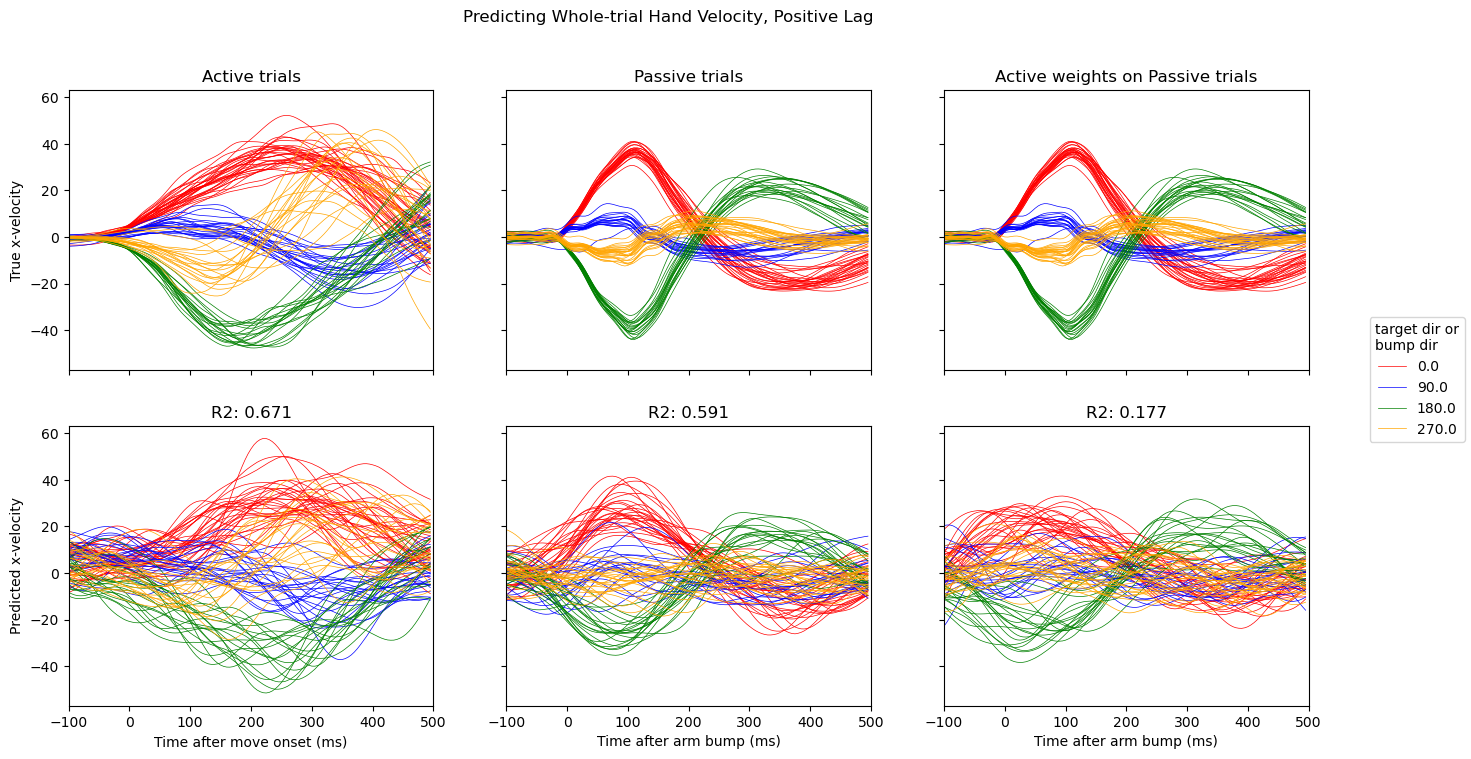

R2: 0.6353622580114426
R2: 0.3871877891991541
R2: -1.1254741018206058


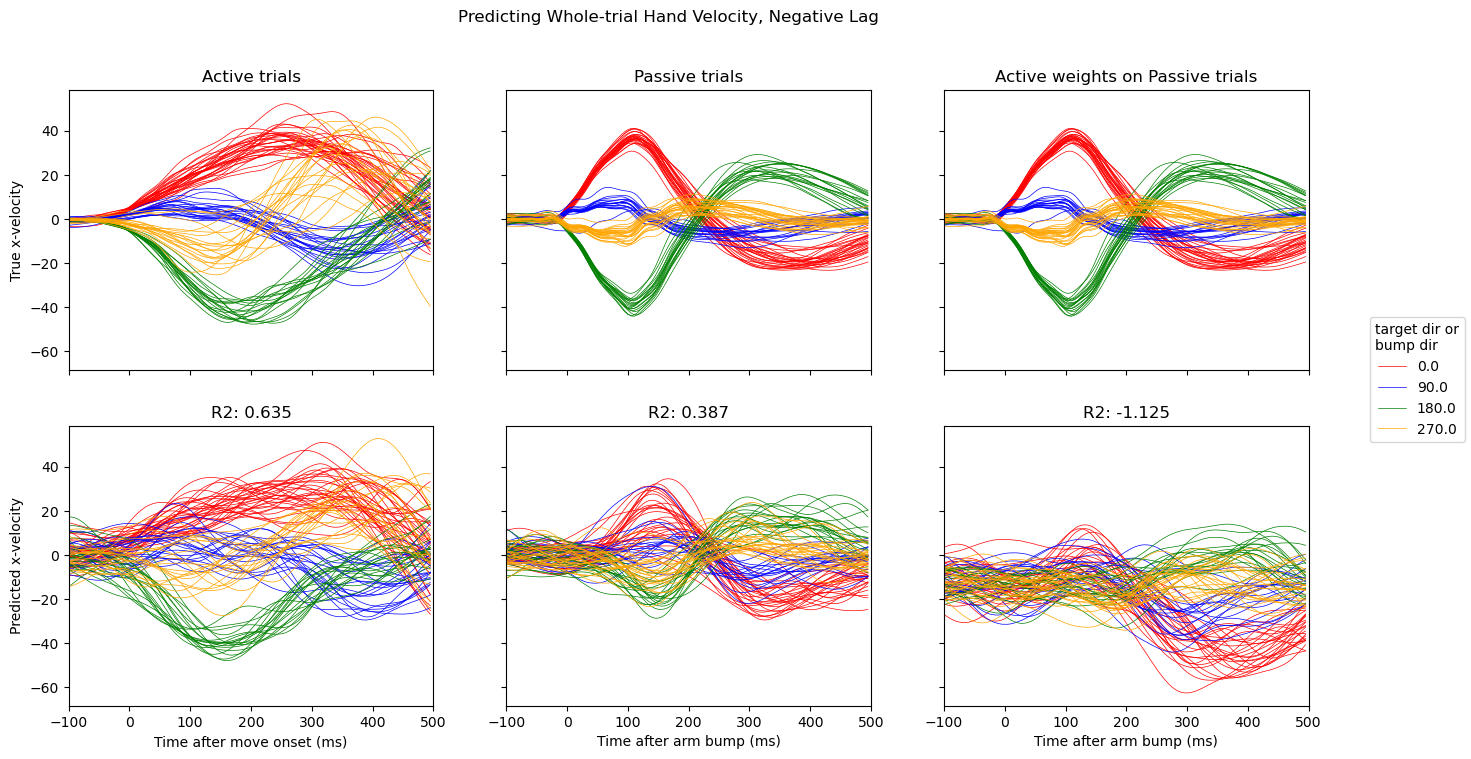

In [8]:
lag = positive_lag
pred_range = (-100,500)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Whole-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time',pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Whole-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()

R2: 0.6831847286740884
R2: 0.7429922555356874
R2: 0.04595093933383887


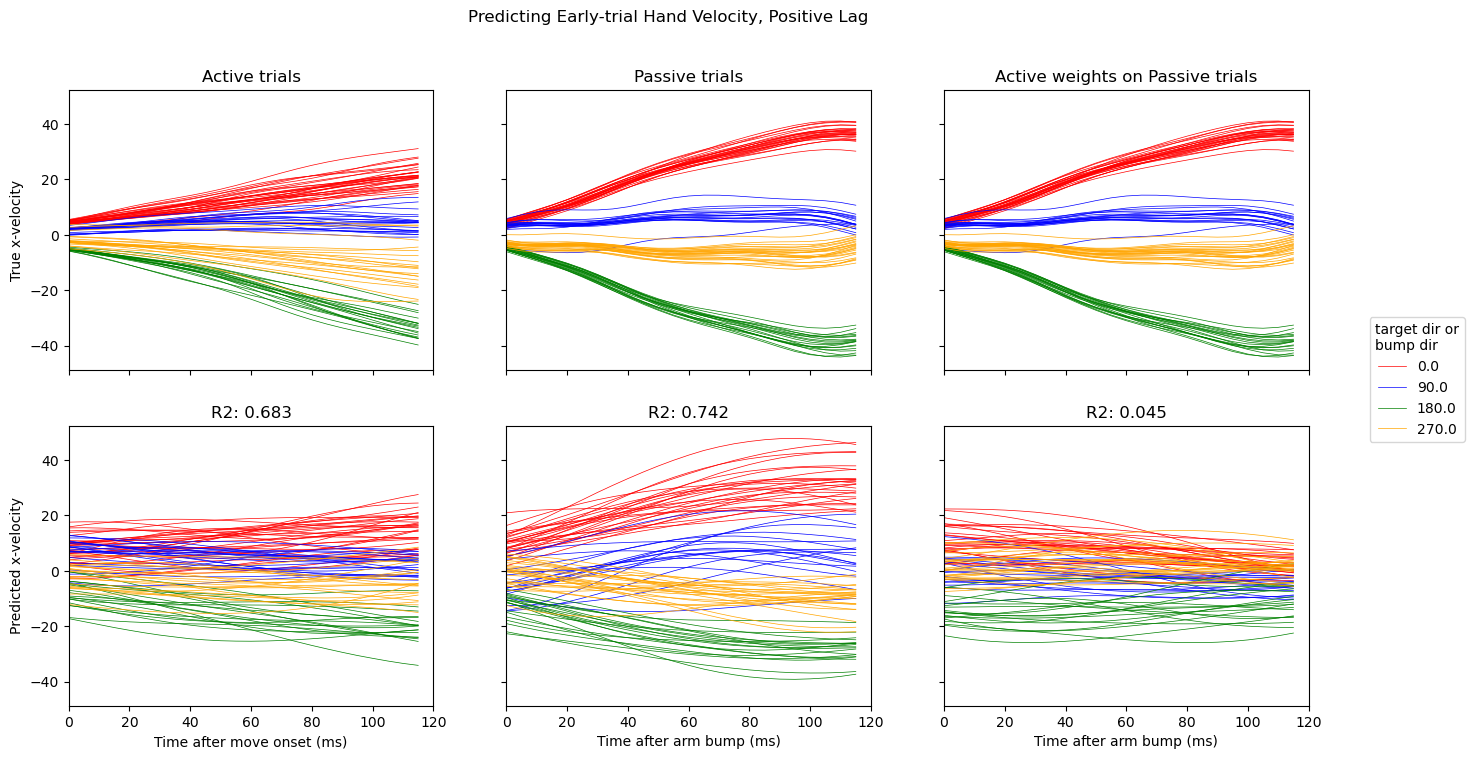

R2: 0.6649443923862853
R2: 0.1151884476636229
R2: -0.20018886265922253


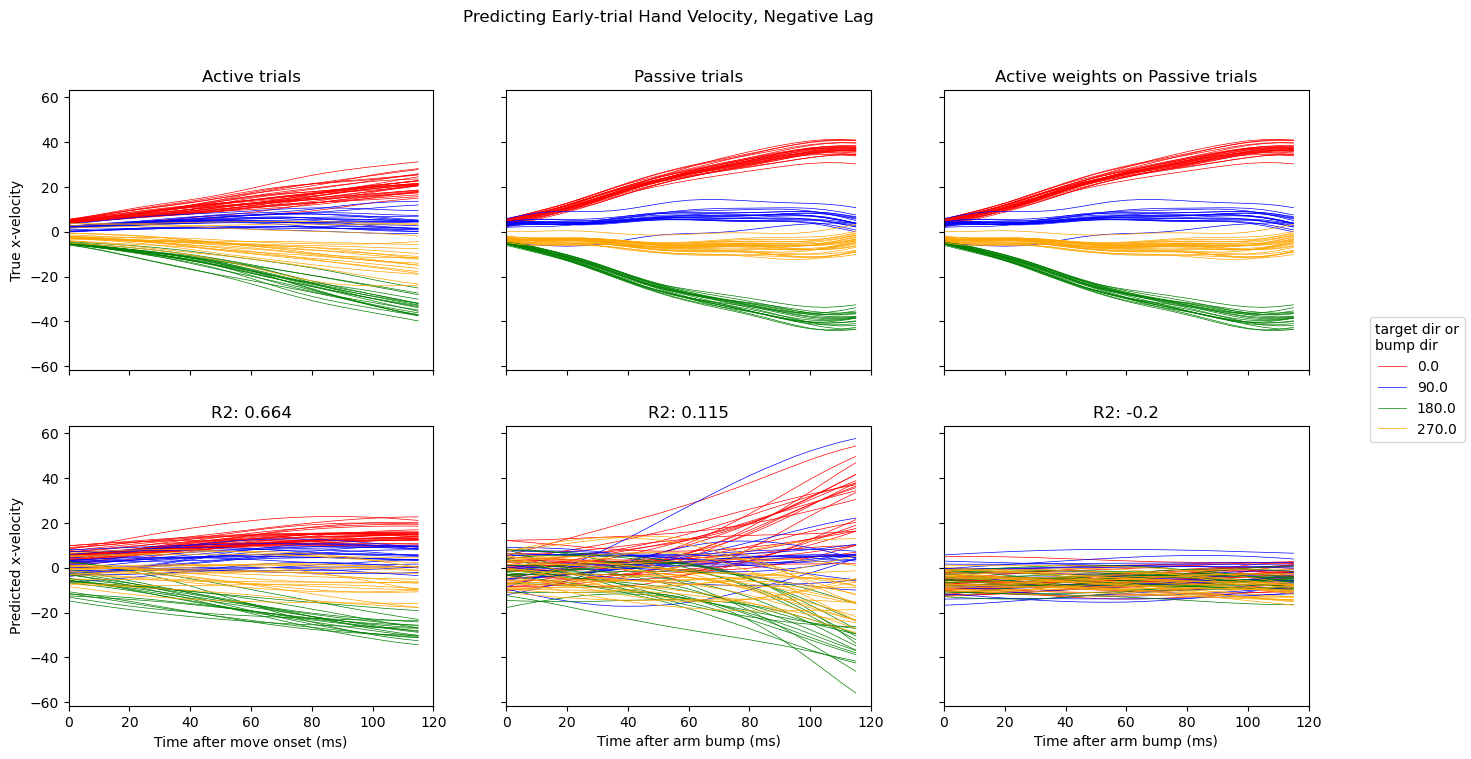

In [9]:
lag = positive_lag
pred_range = (0,120)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Early-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Early-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()

R2: 0.7925354918479577
R2: 0.5576428932735001
R2: -0.939147937279299


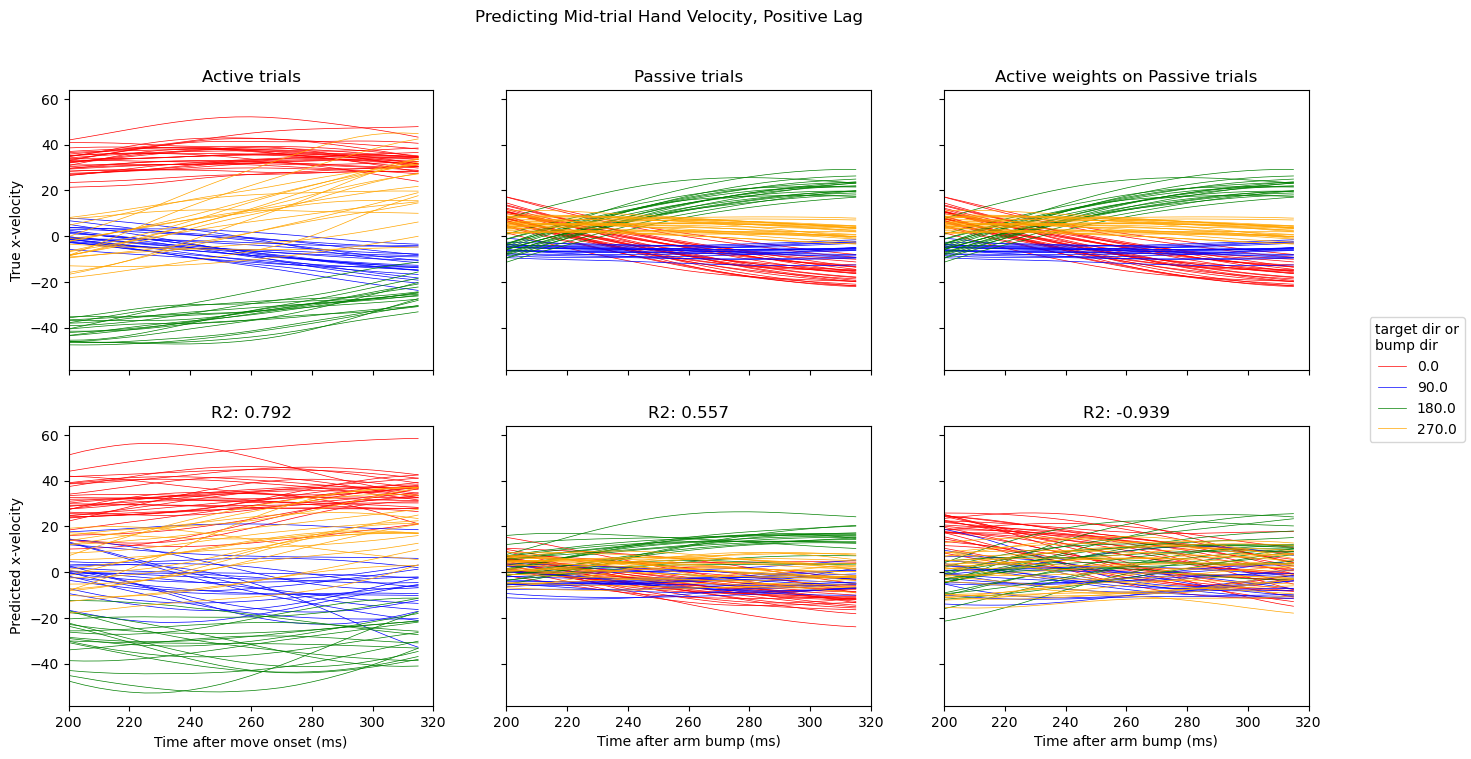

R2: 0.7288751249125778
R2: 0.6076281646981937
R2: -8.027908989476748


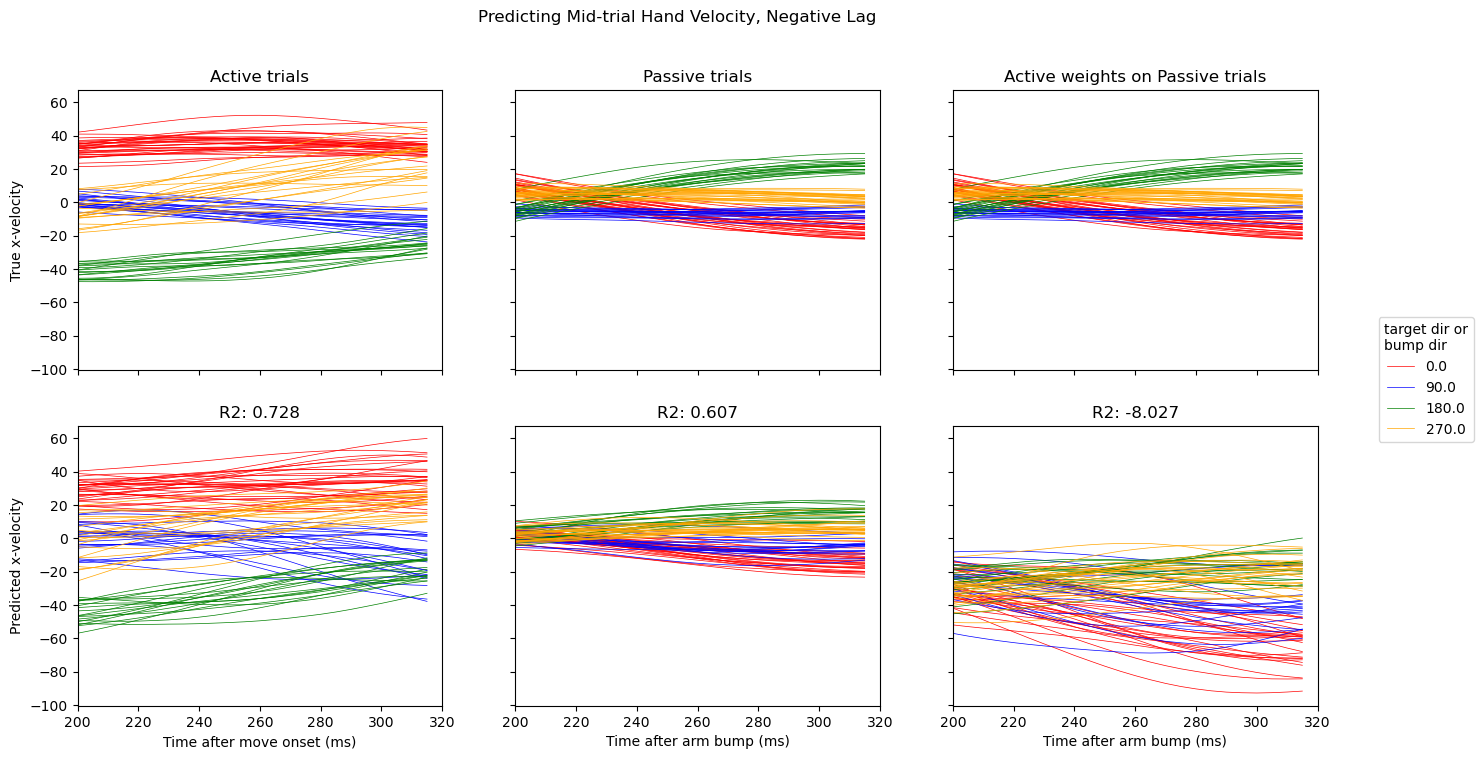

In [10]:
lag = positive_lag
pred_range = (200,320)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Mid-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Mid-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()

R2: 0.49763946681730564
R2: 0.5983957169882753
R2: -0.21387132896730154


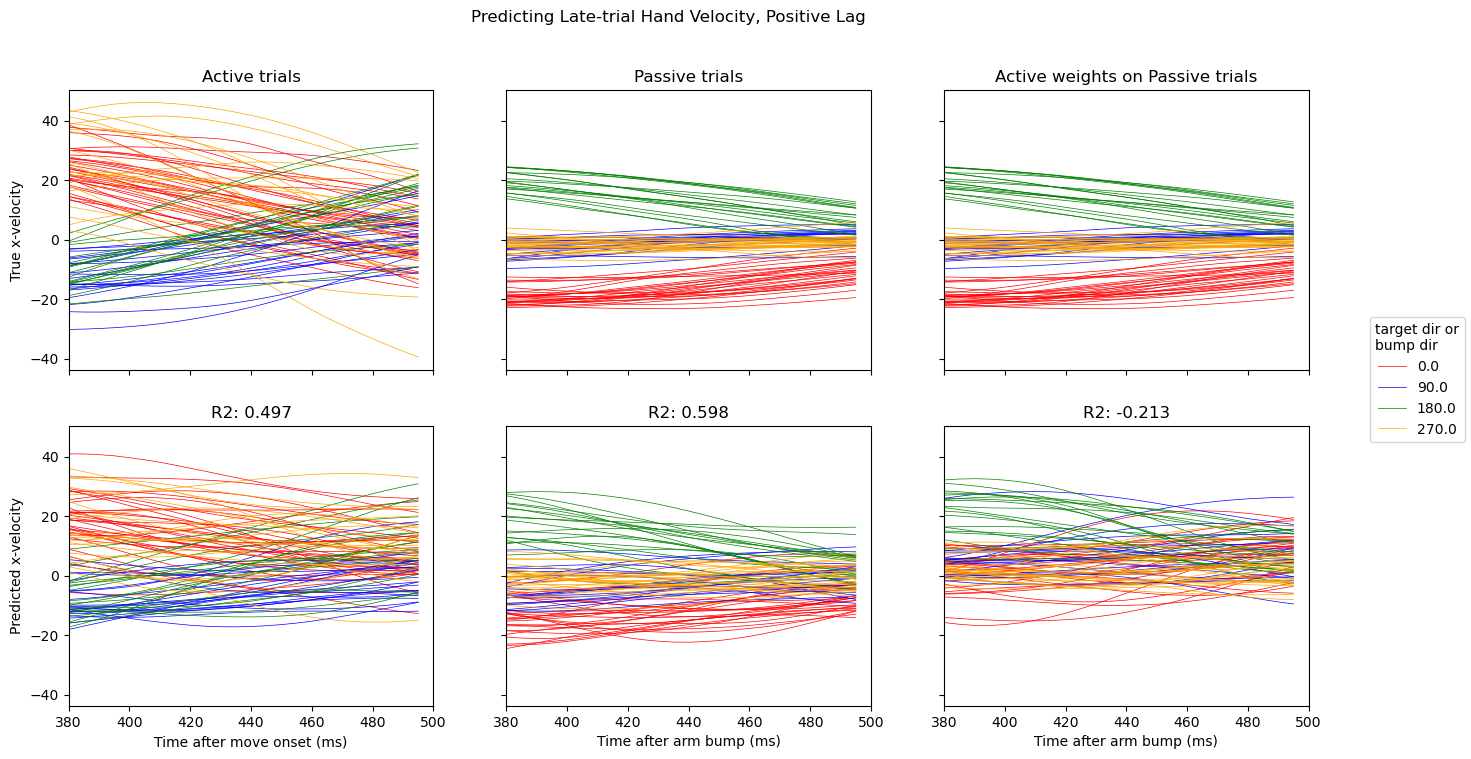

R2: 0.3954413698412842
R2: 0.7572575060276202
R2: 0.5042988378577977


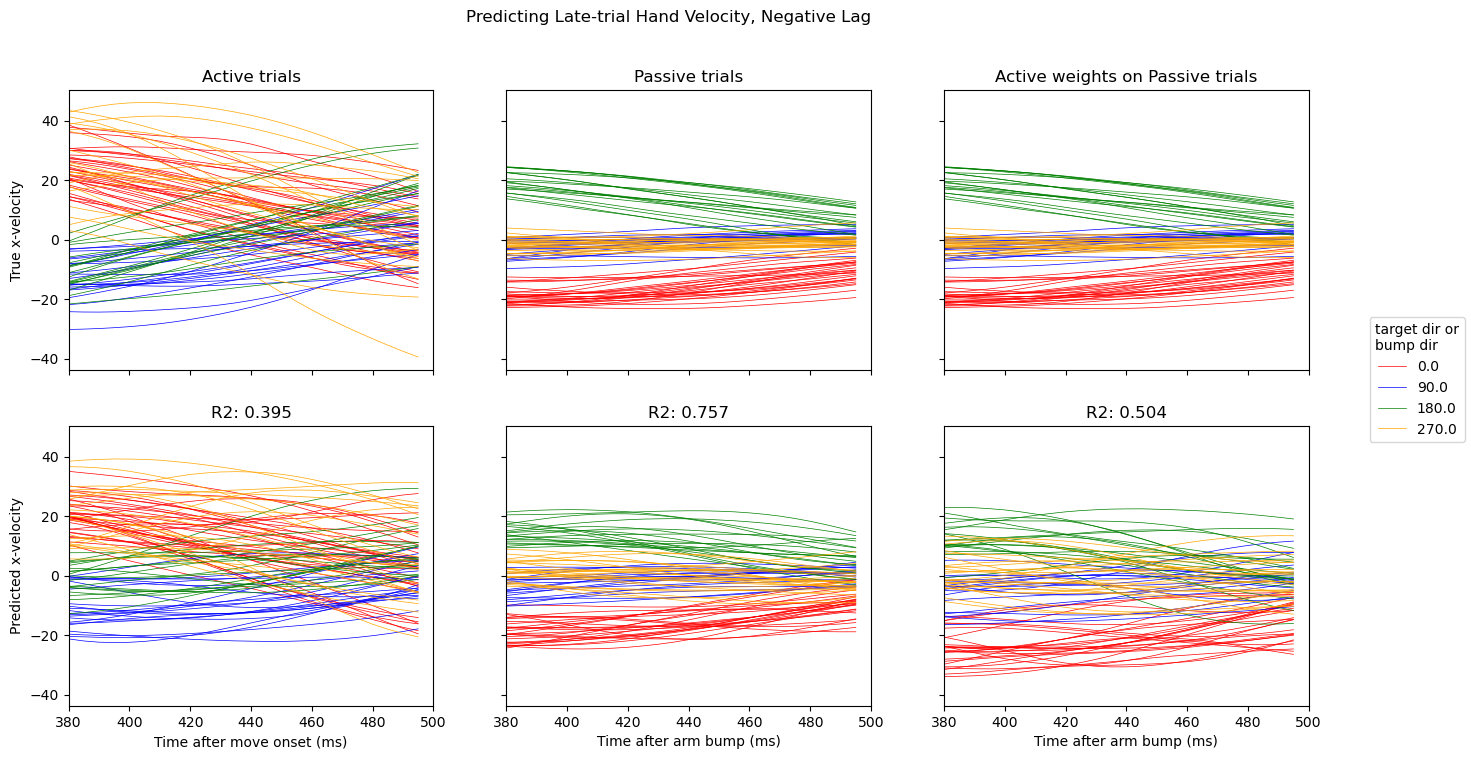

In [11]:
lag = positive_lag
pred_range = (380,500)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Late-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Late-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()

## with PCA

In [12]:
positive_lag = 100
negative_lag = -100
x_field = 'PCA'
y_field ='hand_vel'

# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
plot_dim = 'x' # plot x velocity
colors = ['red', 'blue', 'green', 'orange']

dataset = dataset_5ms

R2: 0.6229540568628722
R2: 0.5011146190196483
R2: 0.09581669525540626


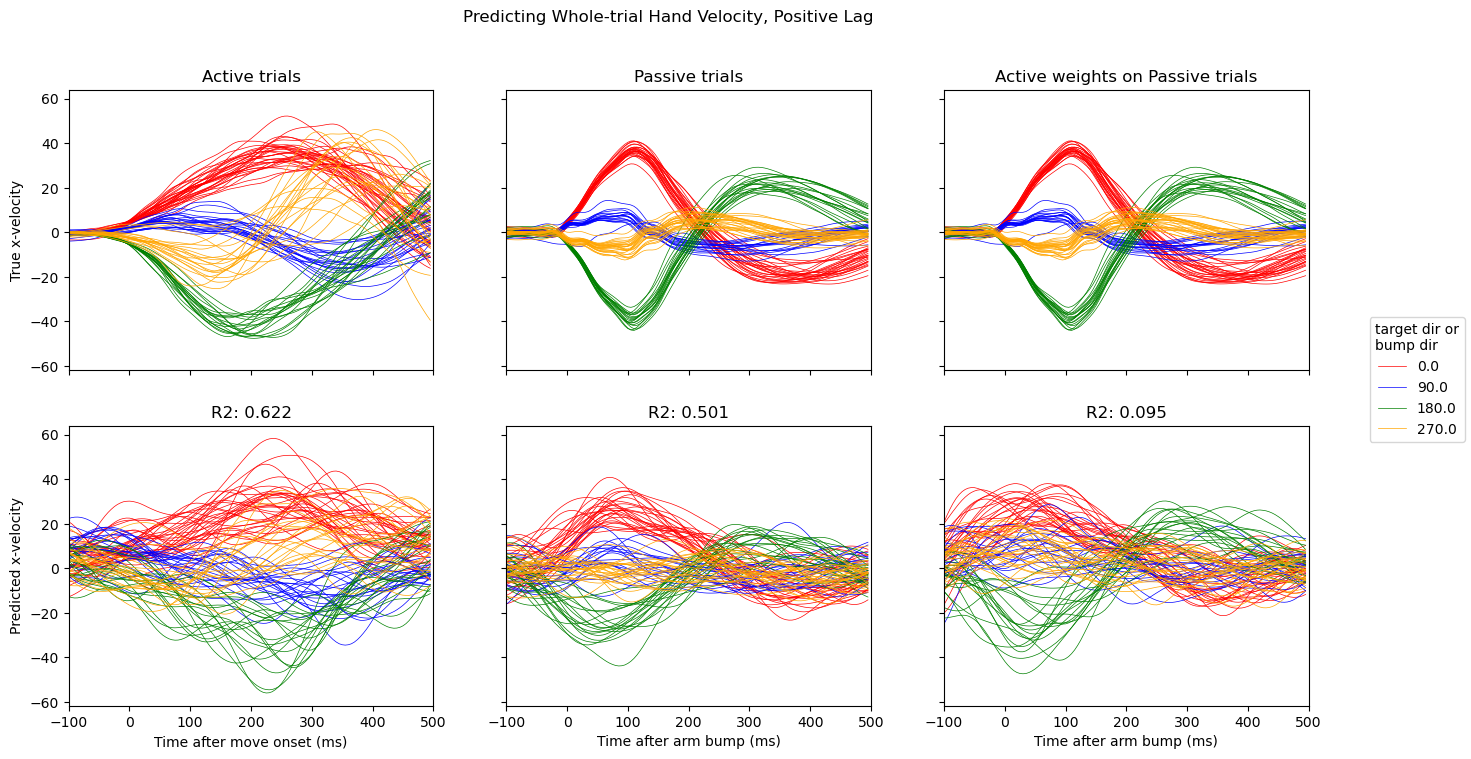

R2: 0.5345626083528581
R2: 0.3660930929452548
R2: -0.048654406307232057


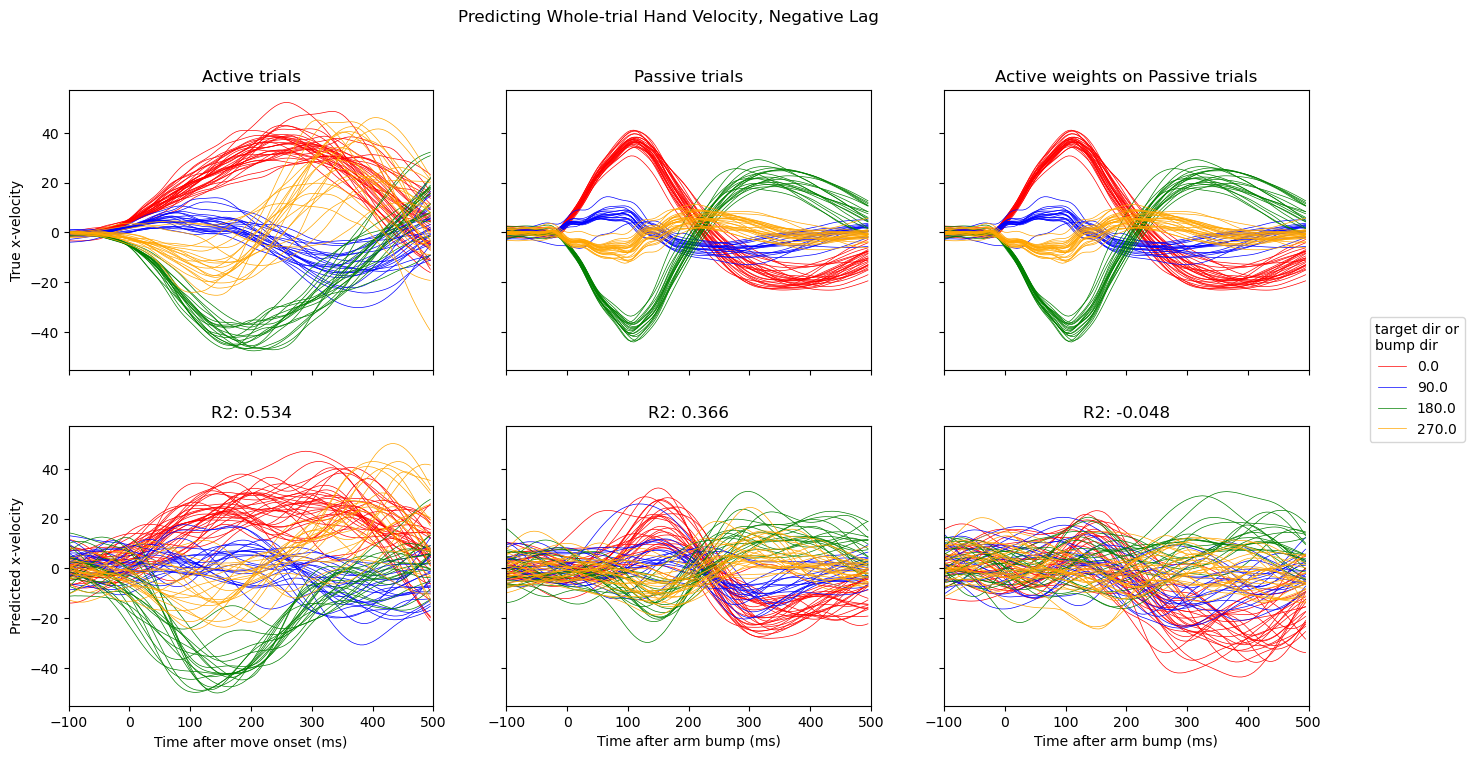

In [13]:
lag = positive_lag
pred_range = (-100,500)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Whole-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time',pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time',pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Whole-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()

R2: 0.6619269646809177
R2: 0.7321499336503191
R2: 0.2670472736345755


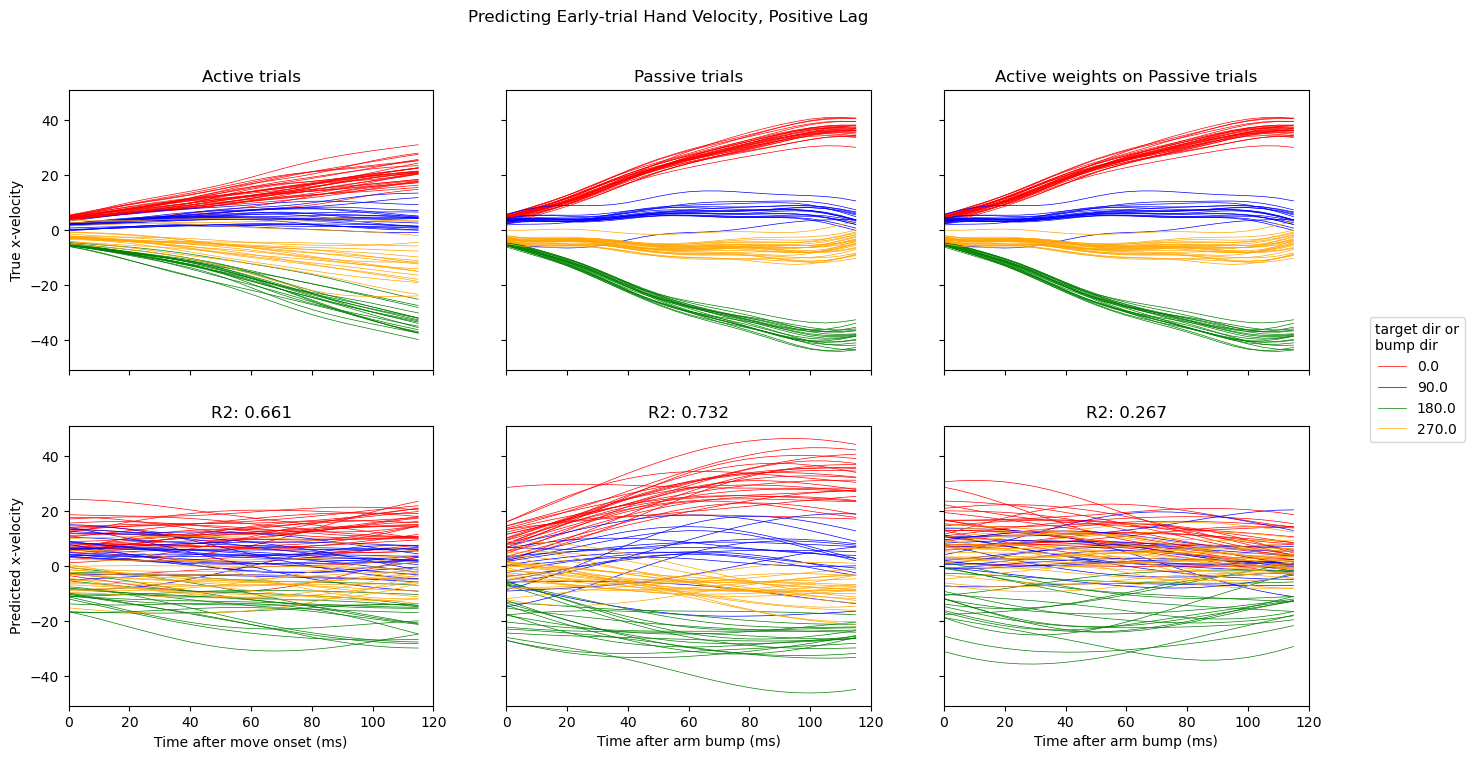

R2: 0.607455067255462
R2: 0.20947084790016324
R2: -0.32090852832864525


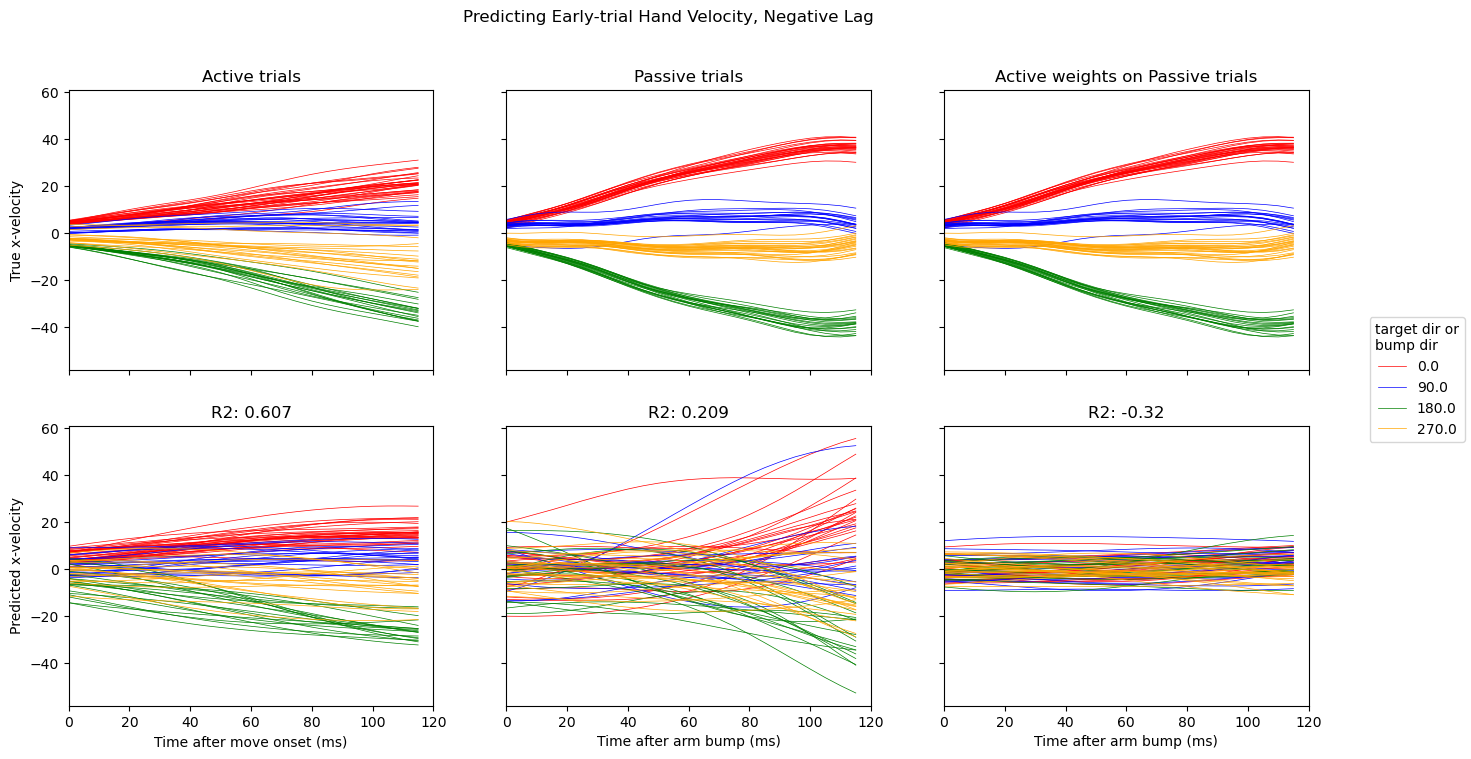

In [14]:
lag = positive_lag
pred_range = (0,120)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Early-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Early-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()

R2: 0.7796096719702004
R2: 0.5171225664822083
R2: -0.31055358556158463


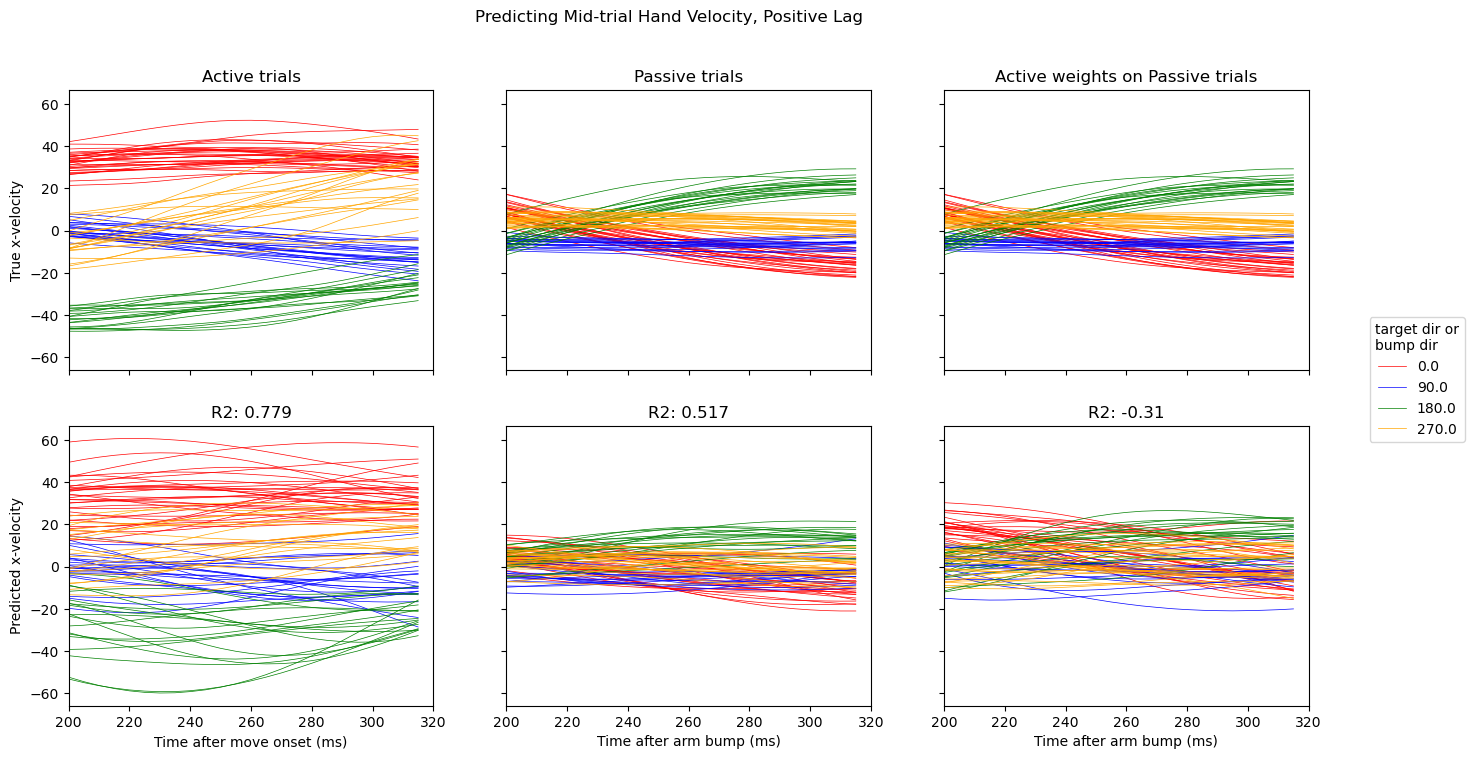

R2: 0.6960185078207817
R2: 0.606975014732366
R2: -1.7657823964160304


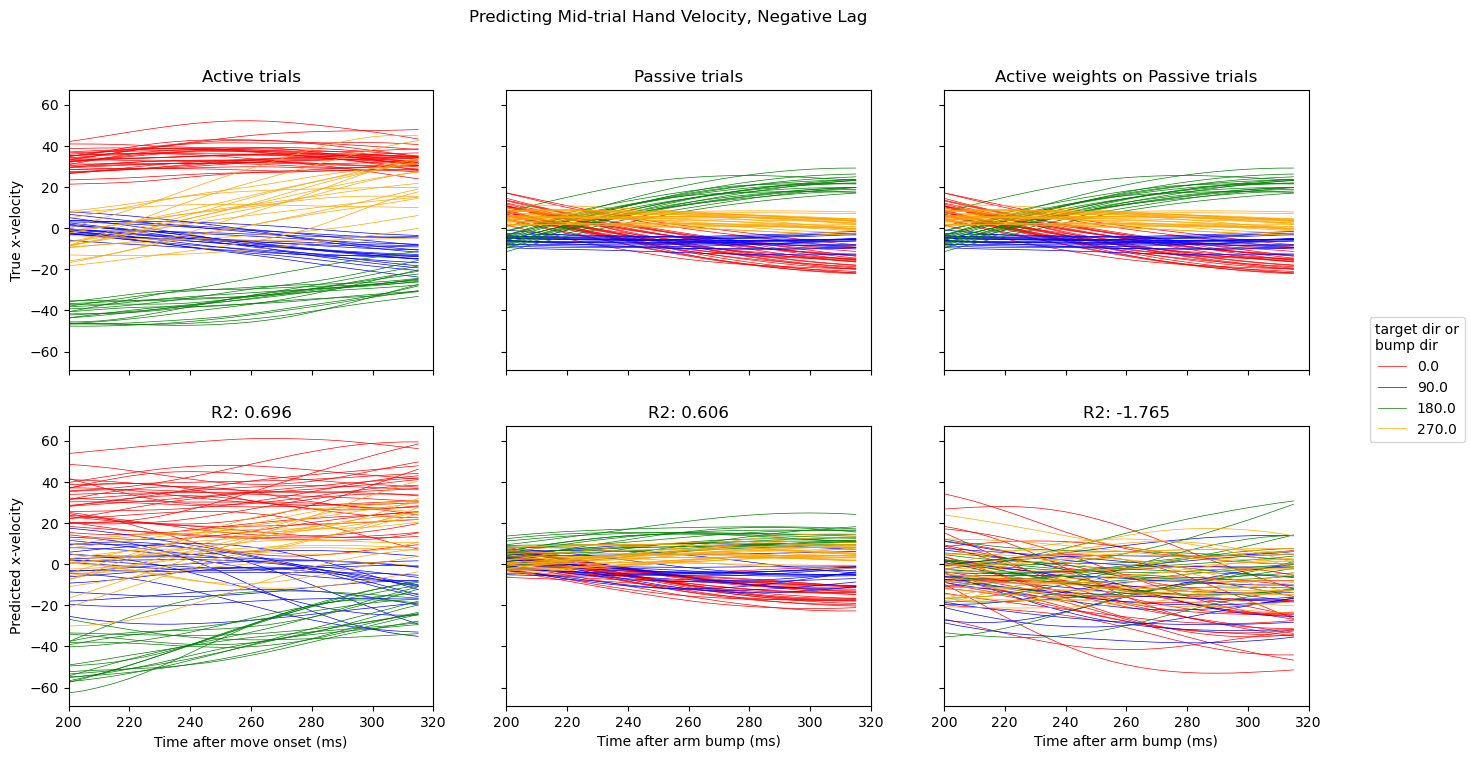

In [15]:
lag = positive_lag
pred_range = (200,320)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Mid-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Mid-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()

R2: 0.4696061184251744
R2: 0.5108659350222844
R2: 0.3044068209545937


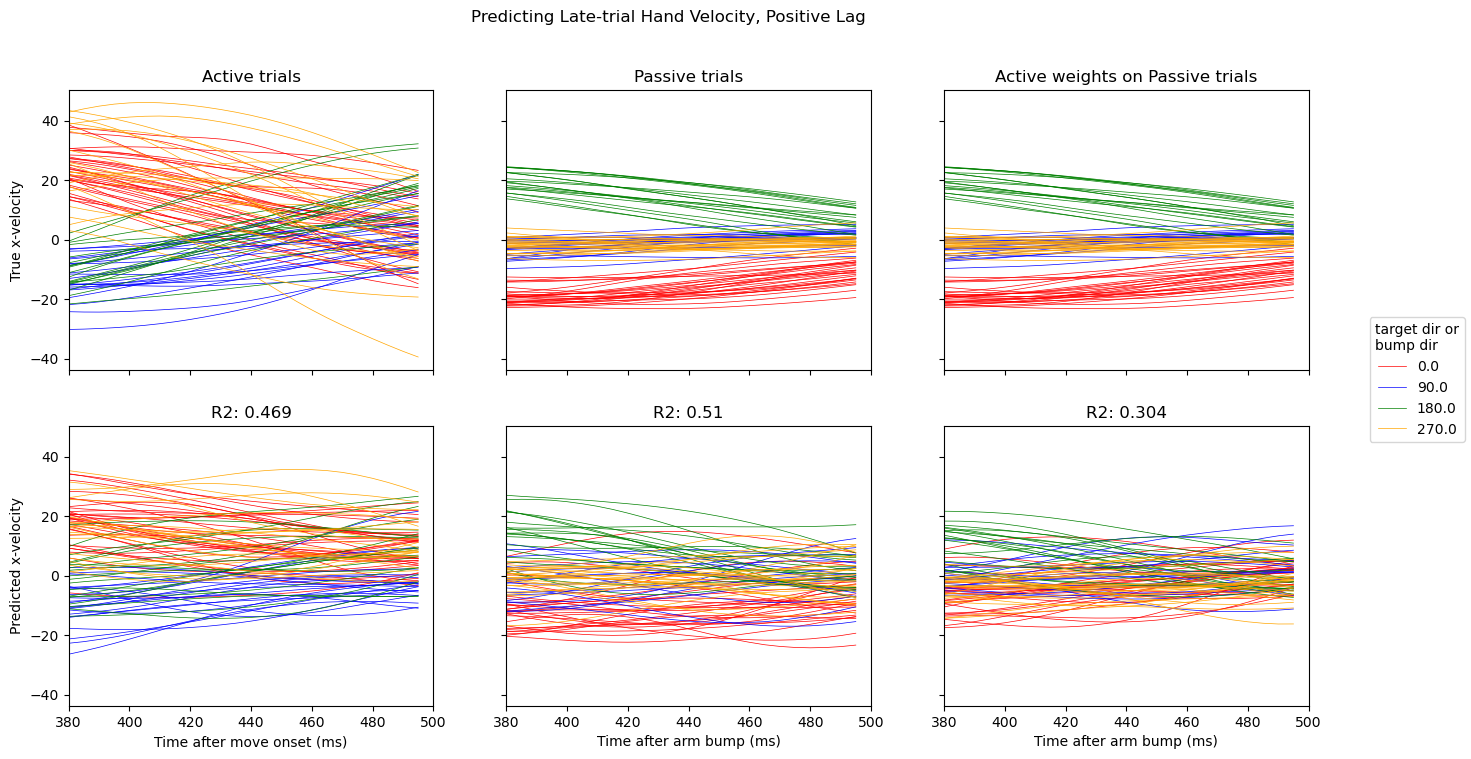

R2: 0.5107517856908514
R2: 0.7755264608550528
R2: 0.6186336270036745


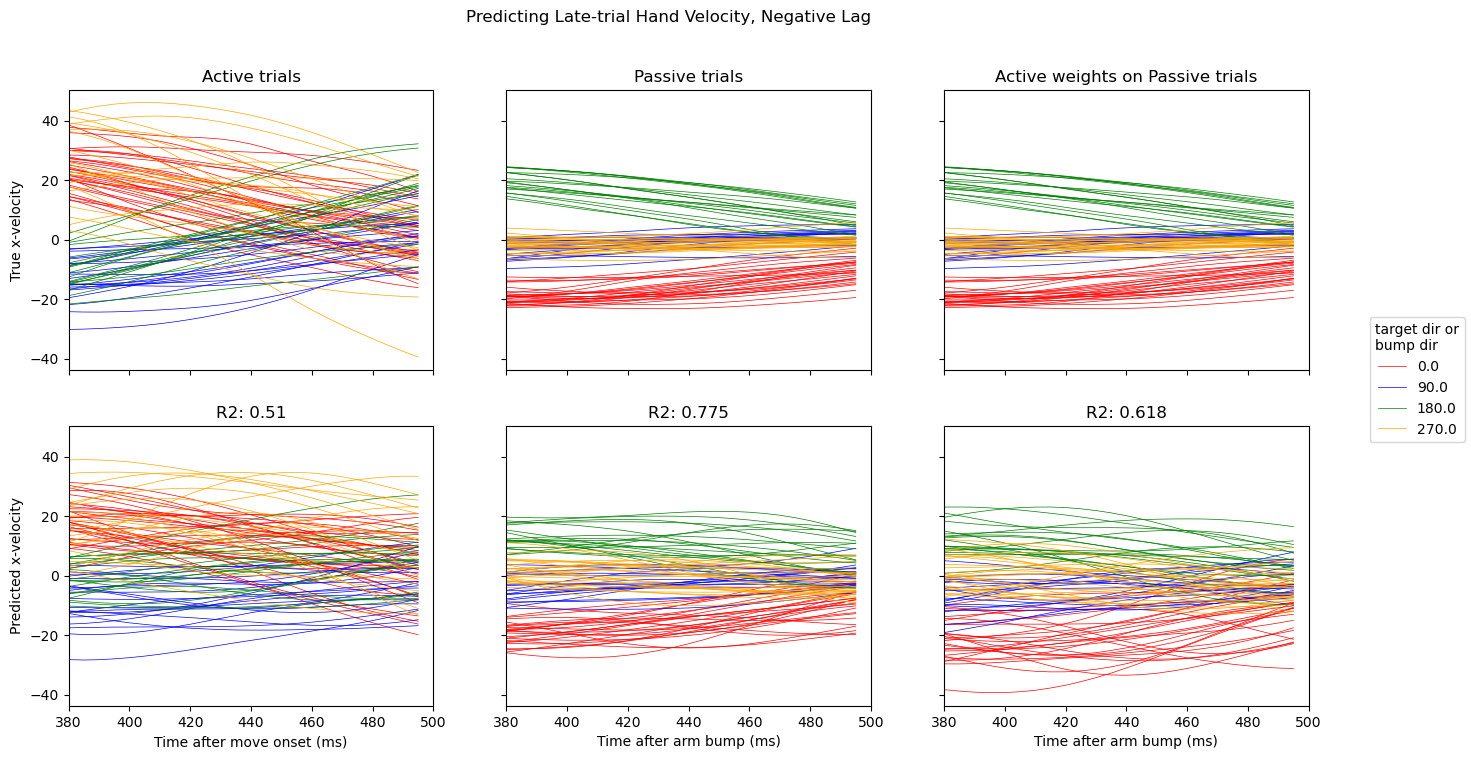

In [16]:
lag = positive_lag
pred_range = (380,500)
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

x_axis = np.arange(pred_range[0], pred_range[1], dataset.bin_width)
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Late-trial Hand Velocity, Positive Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()


lag = negative_lag
actR2, act_weights, act_vel_df = fit_and_predict(dataset, active_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
pasR2, pas_weights, pas_vel_df = fit_and_predict(dataset, passive_mask, 'move_onset_time', pred_range, lag, x_field, y_field)
actOnPas_R2, actOnPas_vel_df = pred_with_new_weights(dataset, passive_mask, 'move_onset_time', pred_range, lag,x_field,y_field, act_weights)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16, 8))
# Loop through trials, plotting true and predicted velocities on appropriate subplot
handles = []; labels = []
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in act_vel_df[np.isin(act_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        hdl = axs[0][0].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][0].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in pas_vel_df[np.isin(pas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][1].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][1].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    for _, trial in actOnPas_vel_df[np.isin(actOnPas_vel_df.trial_id, cond_ids)].groupby('trial_id'):
        axs[0][2].plot(x_axis, trial.hand_vel[plot_dim], color=color, linewidth=0.5)
        axs[1][2].plot(x_axis, trial.pred_vel[plot_dim], color=color, linewidth=0.5)
    handles.append(hdl[0])
    labels.append(trial_dir)

# Add labels
axs[0][0].set_title('Active trials')
axs[0][1].set_title('Passive trials')
axs[0][2].set_title('Active weights on Passive trials')

axs[1][0].set_title('R2: ' + str(int(actR2*1000)/1000))
axs[1][1].set_title('R2: ' + str(int(pasR2*1000)/1000))
axs[1][2].set_title('R2: ' + str(int(actOnPas_R2*1000)/1000))


axs[0][0].set_ylabel(f'True {plot_dim}-velocity')
axs[1][0].set_ylabel(f'Predicted {plot_dim}-velocity')
axs[1][0].set_xlabel('Time after move onset (ms)')
axs[1][1].set_xlabel('Time after arm bump (ms)')
axs[1][2].set_xlabel('Time after arm bump (ms)')
axs[0][0].set_xlim(pred_range)
fig.suptitle('Predicting Late-trial Hand Velocity, Negative Lag')
fig.legend(handles=handles, labels=labels, title='target dir or\nbump dir', loc='right')
plt.show()